In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = '../data'

races = pd.read_csv(data_dir + '/races.csv')
circuits = pd.read_csv(data_dir + '/circuits.csv')
results = pd.read_csv(data_dir + '/results.csv')
drivers = pd.read_csv(data_dir + '/drivers.csv')
status = pd.read_csv(data_dir + '/status.csv')
constructors = pd.read_csv(data_dir + '/constructors.csv')


Circuits in seasons over the years

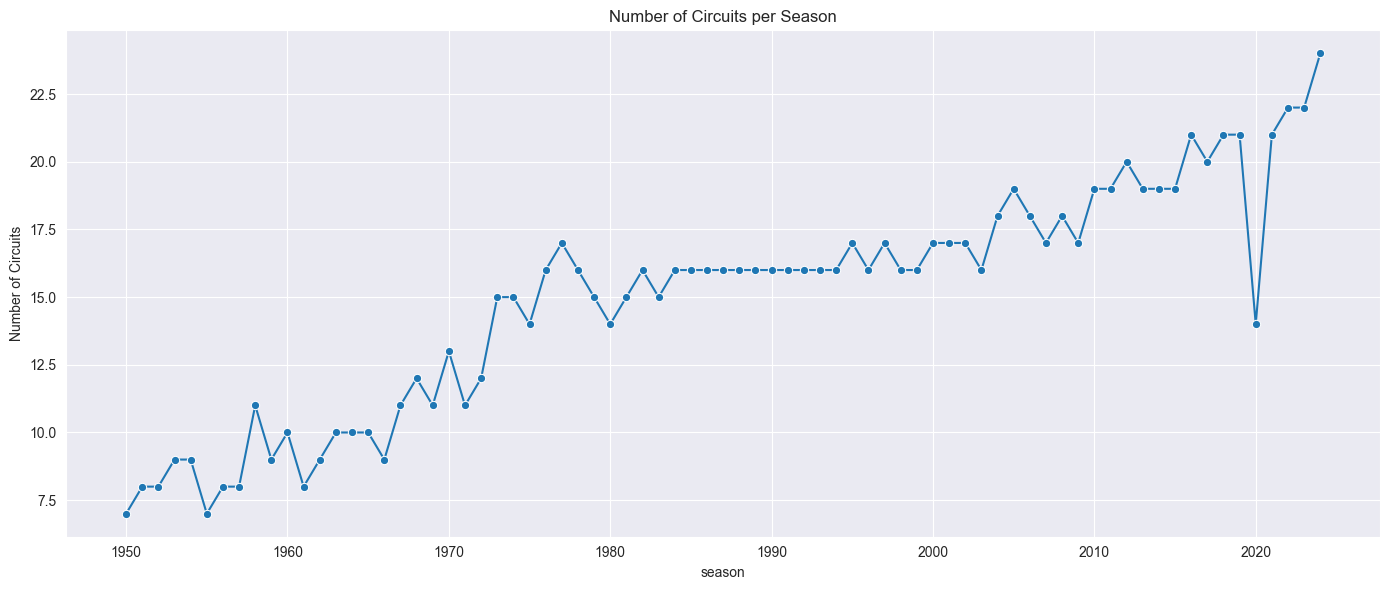

In [11]:
#merge to get names
race_circuits = races.merge(circuits, on="circuitId")

#count circuits per season
circuits_per_season = race_circuits.groupby('year')['circuitId'].nunique().reset_index()
circuits_per_season.columns = ['Season', 'Number of Circuits']

#Plot: Number of circuits per season
plt.figure(figsize = (14,6))
sns.lineplot(data=circuits_per_season, x='Season', y='Number of Circuits', marker='o')
plt.title("Number of Circuits per Season")
plt.xlabel("season")
plt.ylabel("Number of Circuits")
plt.grid(True)
plt.tight_layout()
plt.show()

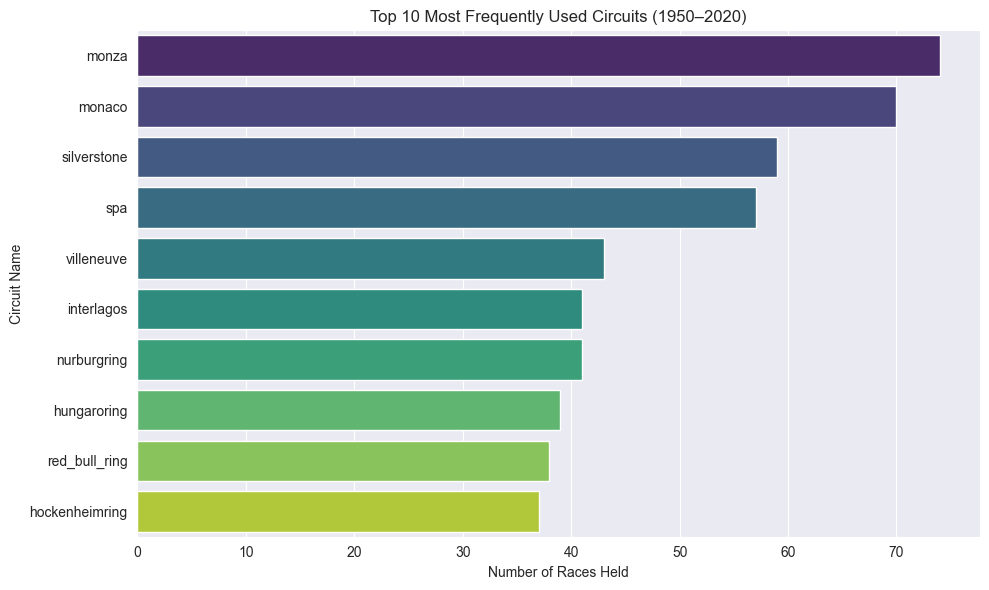

In [12]:
#Which circuits are the most frequent
top_circuits = race_circuits['circuitRef'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_circuits.index, x=top_circuits.values, hue=top_circuits.index, palette="viridis", legend=False)
plt.title("Top 10 Most Frequently Used Circuits (1950–2020)")
plt.xlabel("Number of Races Held")
plt.ylabel("Circuit Name")
plt.tight_layout()
plt.show()


How important is pole position on this track? Pole to win conversion rates

C:\Users\stine\AppData\Local\Temp\ipykernel_19828\2974317185.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pole_conversion_filtered['Circuit'] = pole_conversion_filtered.index.map(circuit_id_to_name)


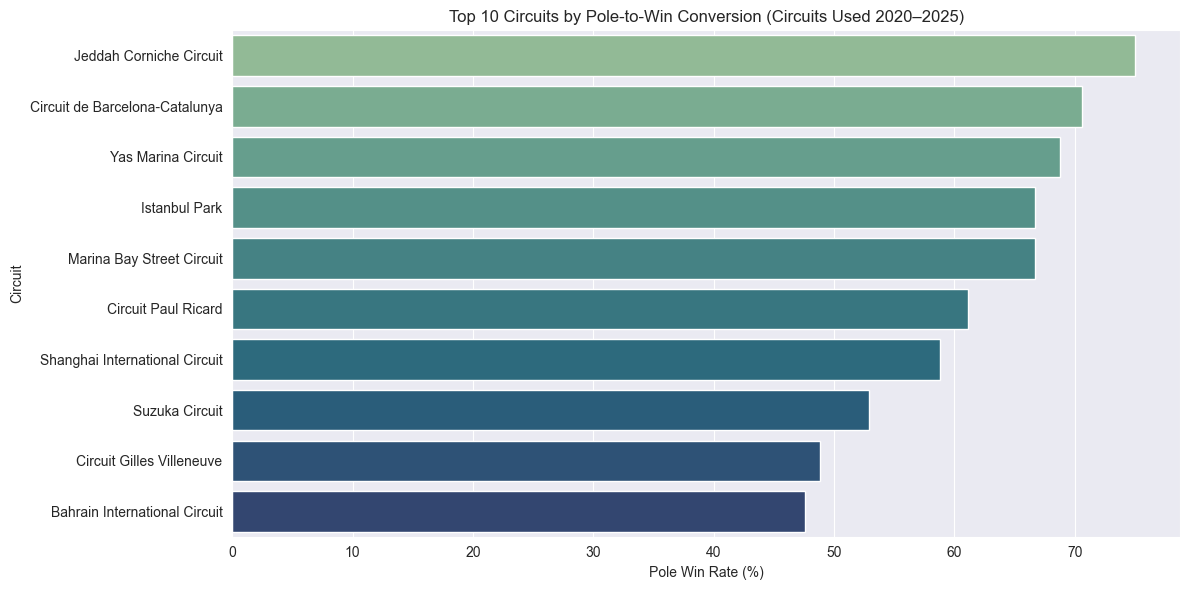

In [29]:
# Identify circuitIds used in races between 2020 and 2025
recent_races = races[races['year'].between(2020, 2025)]
recent_circuit_ids = recent_races['circuitId'].unique()

# Merge results with races to get year and circuit info
results_full = results.merge(races[['raceId', 'circuitId', 'year']], on='raceId')

# Filter to races held at circuits used in the last 5 years
filtered_results = results_full[results_full['circuitId'].isin(recent_circuit_ids)]

# Identify race winners and pole sitters
winners = filtered_results[filtered_results['positionOrder'] == 1][['raceId', 'driverId', 'circuitId']]
pole_sitters = filtered_results[filtered_results['grid'] == 1][['raceId', 'driverId']]

# Merge winners and pole sitters on raceId
merged = winners.merge(pole_sitters, on='raceId', suffixes=('_winner', '_pole'))

# Check if pole sitter won
merged['pole_win'] = merged['driverId_winner'] == merged['driverId_pole']

# Count pole wins per circuit
pole_wins_per_circuit = merged[merged['pole_win']].groupby('circuitId')['raceId'].nunique()

# Count total races per circuit (based on winners, avoids duplicates)
total_races_per_circuit = winners.groupby('circuitId')['raceId'].nunique()

# Combine into one DataFrame
pole_conversion = pd.DataFrame({
    'Total Races': total_races_per_circuit,
    'Pole Wins': pole_wins_per_circuit
}).fillna(0)

# Calculate percentage
pole_conversion['Pole Win Rate (%)'] = (
    pole_conversion['Pole Wins'] / pole_conversion['Total Races']
) * 100

# Filter out circuits with less than 4 total races
pole_conversion_filtered = pole_conversion[pole_conversion['Total Races'] >= 4]

# Add circuit names
circuit_id_to_name = circuits.set_index('circuitId')['name']
pole_conversion_filtered['Circuit'] = pole_conversion_filtered.index.map(circuit_id_to_name)


# Sort and show top 10
top10 = pole_conversion_filtered.sort_values(by='Pole Win Rate (%)', ascending=False).head(10)

# Plot graph
plt.figure(figsize=(12,6))
sns.barplot(data=top10, x='Pole Win Rate (%)', y='Circuit', palette='crest', hue='Circuit', legend=False)
plt.title("Top 10 Circuits by Pole-to-Win Conversion (Circuits Used 2020–2025)")
plt.xlabel("Pole Win Rate (%)")
plt.ylabel("Circuit")
plt.tight_layout()
plt.show()


In [14]:
pole_conversion['Circuit'] = pole_conversion.index.map(circuit_id_to_name)
print(pole_conversion.sort_values(by='Pole Win Rate (%)', ascending=False).head(20))


           Total Races  Pole Wins  Pole Win Rate (%)  \
circuitId                                              
76                   1        1.0         100.000000   
77                   4        3.0          75.000000   
4                   34       24.0          70.588235   
24                  16       11.0          68.750000   
15                  15       10.0          66.666667   
5                    9        6.0          66.666667   
78                   3        2.0          66.666667   
34                  18       11.0          61.111111   
17                  17       10.0          58.823529   
22                  34       18.0          52.941176   
80                   2        1.0          50.000000   
75                   2        1.0          50.000000   
7                   43       21.0          48.837209   
3                   21       10.0          47.619048   
39                  34       16.0          47.058824   
32                  24       11.0          45.83

What is the impact of racing in your home country?

In [15]:
# Merge everything together
races = races.merge(circuits[['circuitId', 'country']], on='circuitId')
results_full = results.merge(races[['raceId', 'year', 'country']], on='raceId')
results_full = results_full.merge(drivers[['driverId', 'nationality', 'surname']], on='driverId')

# Mapping: Nationality → Home Country
home_country_map = {
    'British': 'UK',
    'German': 'Germany',
    'Spanish': 'Spain',
    'Finnish': 'Finland',
    'French': 'France',
    'Italian': 'Italy',
    'Brazilian': 'Brazil',
    'Dutch': 'Netherlands',
    'Mexican': 'Mexico',
    'Australian': 'Australia',
    'Japanese': 'Japan',
    'Canadian': 'Canada',
    'Monegasque': 'Monaco',
    'American': 'USA',
}

# Add a 'home_race' column
results_full['home_country'] = results_full['nationality'].map(home_country_map)
results_full['is_home_race'] = results_full['home_country'] == results_full['country']

# Only use classified finishes
classified = results_full[results_full['positionOrder'].notnull()]

# Average finishing position
home_avg = classified[classified['is_home_race'] == True]['positionOrder'].mean()
away_avg = classified[classified['is_home_race'] == False]['positionOrder'].mean()

print(f" Home race avg finish: {home_avg:.2f}")
print(f" Non-home race avg finish: {away_avg:.2f}")

# Win = positionOrder == 1
home_wins = classified[(classified['is_home_race']) & (classified['positionOrder'] == 1)].shape[0]
home_total = classified[classified['is_home_race']].shape[0]

away_wins = classified[(~classified['is_home_race']) & (classified['positionOrder'] == 1)].shape[0]
away_total = classified[~classified['is_home_race']].shape[0]

home_win_rate = home_wins / home_total * 100
away_win_rate = away_wins / away_total * 100

print(f" Home win rate: {home_win_rate:.2f}%")
print(f" Away win rate: {away_win_rate:.2f}%")

 Home race avg finish: 14.28
 Non-home race avg finish: 12.66
 Home win rate: 3.83%
 Away win rate: 4.25%


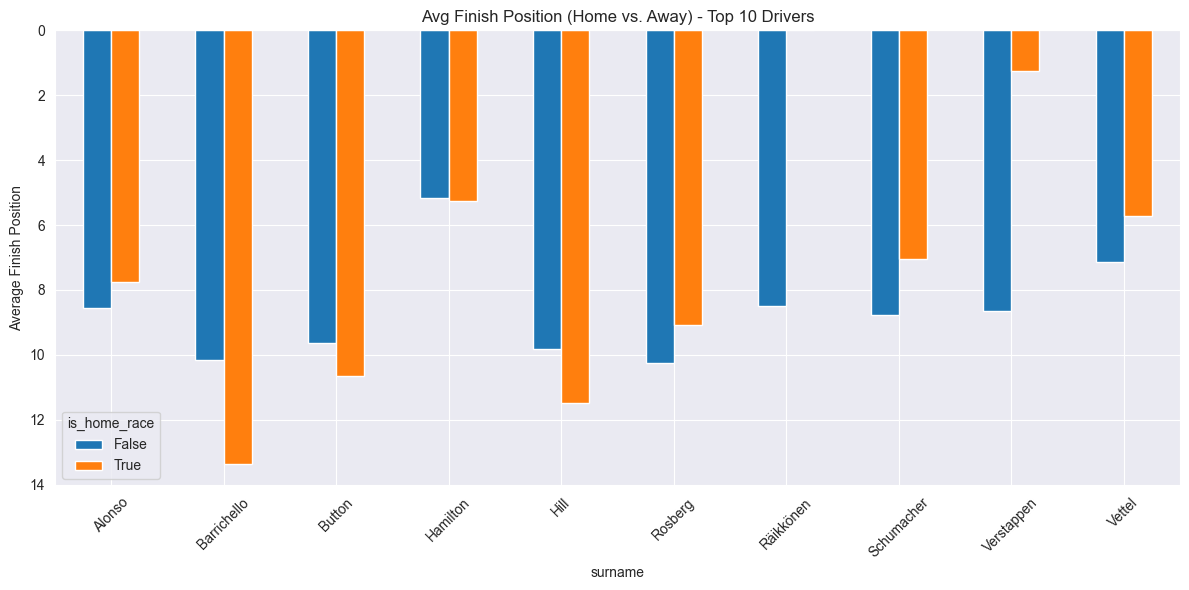

In [16]:
top_drivers = classified['surname'].value_counts().head(10).index

home_vs_away = classified[classified['surname'].isin(top_drivers)].groupby(
    ['surname', 'is_home_race']
)['positionOrder'].mean().unstack()

home_vs_away.plot(kind='bar', figsize=(12,6))
plt.title("Avg Finish Position (Home vs. Away) - Top 10 Drivers")
plt.ylabel("Average Finish Position")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # Lower is better (P1)
plt.tight_layout()
plt.show()


Most dangerous circuits?

In [17]:
# Merge statuses into results
results_status = results.merge(status, on='statusId')

# Add race and circuit info
results_status = results_status.merge(races[['raceId', 'circuitId', 'year']], on='raceId')
results_status = results_status.merge(circuits[['circuitId', 'name', 'location', 'country']], on='circuitId')


# Convert to lowercase and filter
crash_keywords = ['collision', 'accident', 'crash', 'spun off', 'damage']
results_status['status_lower'] = results_status['status'].str.lower()

# Filter rows with crash-related statuses
crashes = results_status[results_status['status_lower'].str.contains('|'.join(crash_keywords))]


# Count incidents per circuit
circuit_crash_counts = crashes.groupby(['name', 'country']).size().reset_index(name='crash_count')

# Sort descending
circuit_crash_counts = circuit_crash_counts.sort_values('crash_count', ascending=False)

# Show top 10
circuit_crash_counts.head(10)


# Count total races per circuit
races_per_circuit = races['circuitId'].value_counts().reset_index()
races_per_circuit.columns = ['circuitId', 'total_races']

# Add circuit name for merge
races_per_circuit = races_per_circuit.merge(circuits[['circuitId', 'name']], on='circuitId')

# Merge crash count with races held
circuit_crash_counts = circuit_crash_counts.merge(races_per_circuit, on='name')

# Normalize
circuit_crash_counts['crashes_per_race'] = circuit_crash_counts['crash_count'] / circuit_crash_counts['total_races']

# Top 10 normalized
circuit_crash_counts.sort_values('crashes_per_race', ascending=False).head(10)


,name,country,crash_count,circuitId,total_races,crashes_per_race
41,Fair Park,USA,13,42,1,13.000000
17,Long Beach,USA,52,43,8,6.500000
56,Autodromo Internazionale del Mugello,Italy,6,76,1,6.000000
55,Donington Park,UK,6,31,1,6.000000
16,Adelaide Street Circuit,Australia,58,29,11,5.272727
18,Zolder,Belgium,52,40,10,5.200000
25,Detroit Street Circuit,USA,36,37,7,5.142857
59,Ain Diab,Morocco,5,64,1,5.000000
9,Indianapolis Motor Speedway,USA,87,19,19,4.578947
47,Okayama International Circuit,Japan,9,28,2,4.500000


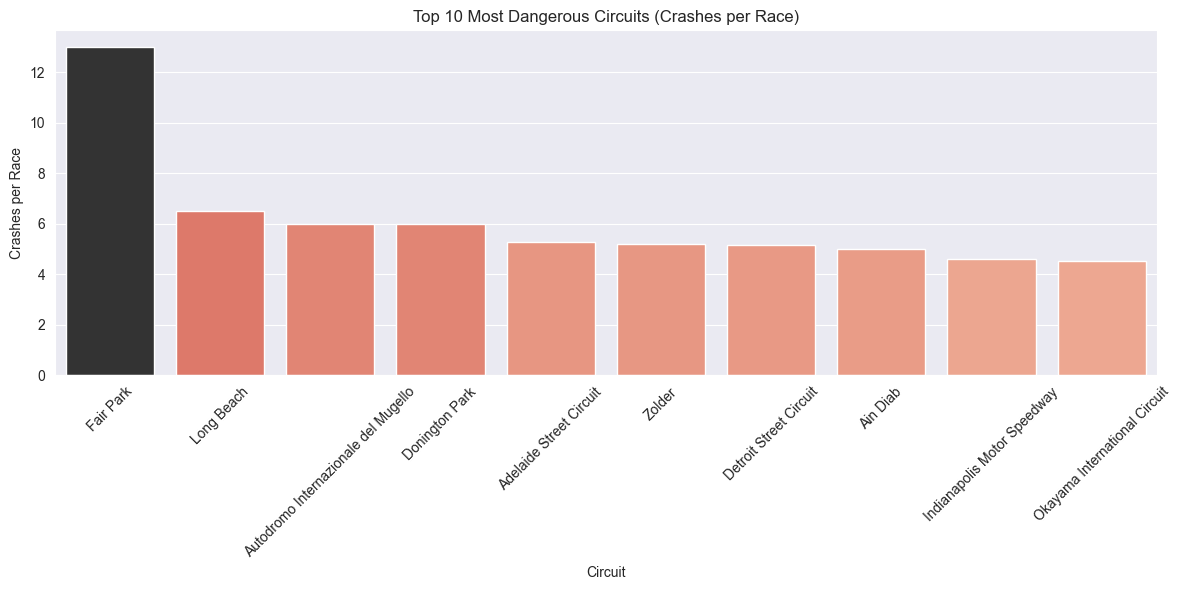

In [30]:
top_10 = circuit_crash_counts.sort_values('crashes_per_race', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_10, x='name', y='crashes_per_race', palette='Reds_d', hue='crashes_per_race', legend=False)
plt.xticks(rotation=45)
plt.title('Top 10 Most Dangerous Circuits (Crashes per Race)')
plt.ylabel('Crashes per Race')
plt.xlabel('Circuit')
plt.tight_layout()
plt.show()


Most car failures by team

In [19]:
# Merge status into results
results_status = results.merge(status, on="statusId", how="left")
results_status = results_status.merge(constructors[["constructorId", "name"]], on="constructorId", how="left")

# Merge year from races
results_status = results_status.merge(races[["raceId", "year"]], on="raceId", how="left")

# Lowercase status for keyword filtering
results_status["status_lower"] = results_status["status"].str.lower()

# Keywords to exclude (non-mechanical failures)
exclude_keywords = ['collision', 'accident', 'crash', 'spun off', 'damage', 'disqualified', 'withdrew', 'excluded', 'lap', 'did not start', 'ineligible', 'fuel']

# Only include mechanical/technical failures (not finished, not excluded)
failures = results_status[
    (~results_status["status_lower"].str.contains('|'.join(exclude_keywords))) &
    (results_status["status_lower"] != "finished")
]

# Optional: Filter to modern era (e.g. since 2000)
modern_failures = failures[failures["year"] >= 2000]
modern_results = results_status[results_status["year"] >= 2000]

# Failure counts
constructor_failures = modern_failures.groupby("name").size().reset_index(name="failures")
total_entries = modern_results.groupby("name").size().reset_index(name="entries")

# Merge and normalize
failures_normalized = constructor_failures.merge(total_entries, on="name")
failures_normalized["failures_per_entry"] = failures_normalized["failures"] / failures_normalized["entries"]

# Sort by normalized failure rate
top_normalized = failures_normalized.sort_values("failures_per_entry", ascending=False).head(10)
bottom_normalized = failures_normalized.sort_values("failures_per_entry", ascending=True).head(10)


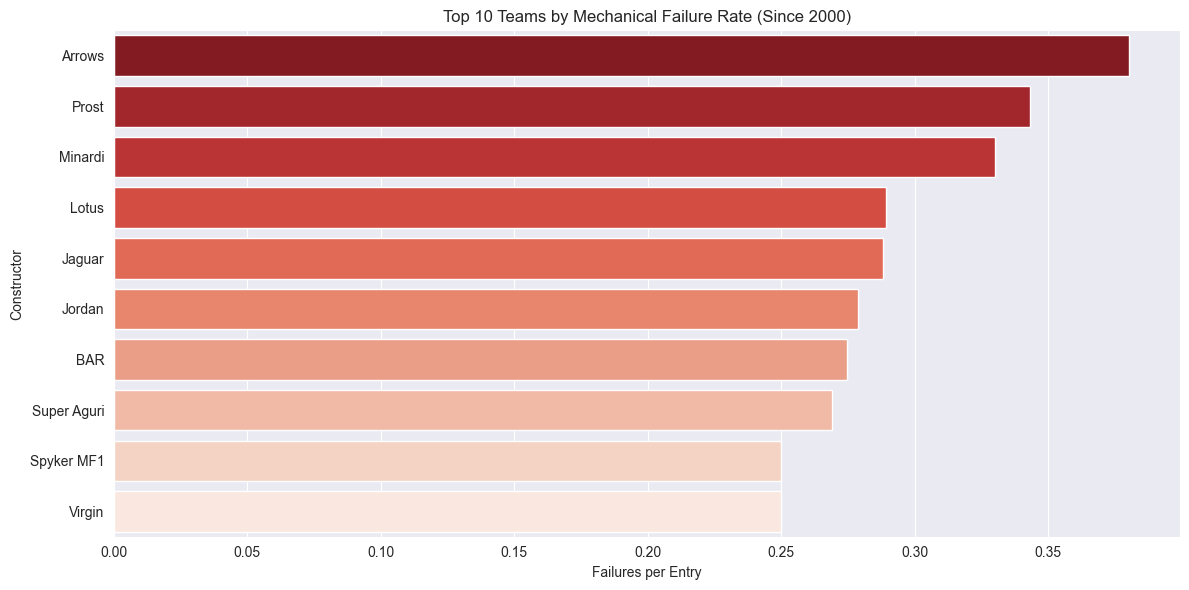

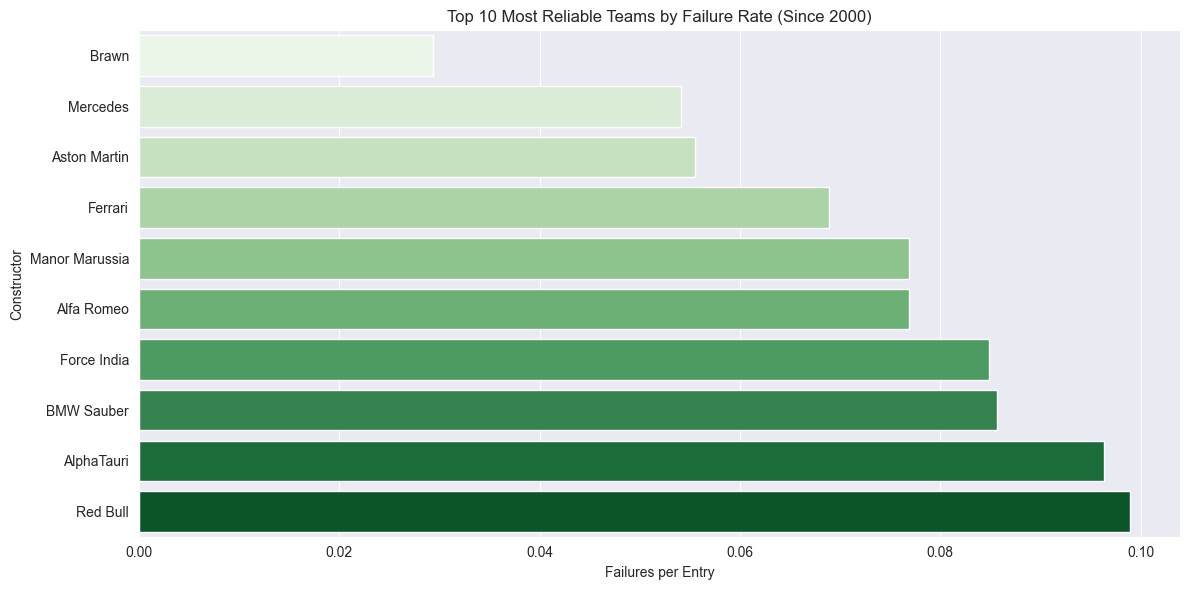

In [32]:
plt.figure(figsize=(12,6))
sns.barplot(data=top_normalized, x="failures_per_entry", y="name", palette="Reds_r", hue="name", legend=False)
plt.title("Top 10 Teams by Mechanical Failure Rate (Since 2000)")
plt.xlabel("Failures per Entry")
plt.ylabel("Constructor")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=bottom_normalized, x="failures_per_entry", y="name", palette="Greens", hue="name", legend=False)
plt.title("Top 10 Most Reliable Teams by Failure Rate (Since 2000)")
plt.xlabel("Failures per Entry")
plt.ylabel("Constructor")
plt.tight_layout()
plt.show()


Whose more prone to crash. Crash ratio for 2020 to current grid

In [21]:
# Merge all data
merged = results.merge(status, on="statusId", how="left") \
                .merge(drivers[["driverId", "surname"]], on="driverId", how="left") \
                .merge(races[["raceId", "year"]], on="raceId", how="left")

# Filter 2020 onwards
merged = merged[merged["year"] >= 2020]


# Normalize status text
merged["status_lower"] = merged["status"].str.lower()

# Define crash-related status
crash_keywords = ["accident", "collision", "crash", "spun off", "damage"]

# Create crash flag
merged["is_crash"] = merged["status_lower"].str.contains('|'.join(crash_keywords))
# Normalize status text
merged["status_lower"] = merged["status"].str.lower()

# Define crash-related status
crash_keywords = ["accident", "collision", "crash", "spun off", "damage"]

# Create crash flag
merged["is_crash"] = merged["status_lower"].str.contains('|'.join(crash_keywords))



# Total races per driver
total_races = merged.groupby("surname").size().reset_index(name="total_races")

# Total crashes per driver
total_crashes = merged[merged["is_crash"]].groupby("surname").size().reset_index(name="crashes")

# Merge and calculate crash ratio
crash_stats = total_races.merge(total_crashes, on="surname", how="left").fillna(0)
crash_stats["crash_ratio"] = crash_stats["crashes"] / crash_stats["total_races"]

# Filter out drivers with very few races (e.g., <5)
crash_stats = crash_stats[crash_stats["total_races"] >= 5]



crash_stats_sorted = crash_stats.sort_values("crash_ratio", ascending=False)
crash_stats_sorted.head(10)


,surname,total_races,crashes,crash_ratio
5,Colapinto,9,2.0,0.222222
35,de Vries,11,2.0,0.181818
15,Latifi,61,9.0,0.147541
28,Sargeant,36,5.0,0.138889
19,Mazepin,22,3.0,0.136364
10,Grosjean,15,2.0,0.133333
18,Magnussen,83,10.0,0.120482
1,Albon,84,9.0,0.107143
30,Stroll,106,11.0,0.103774
23,Pérez,105,9.0,0.085714


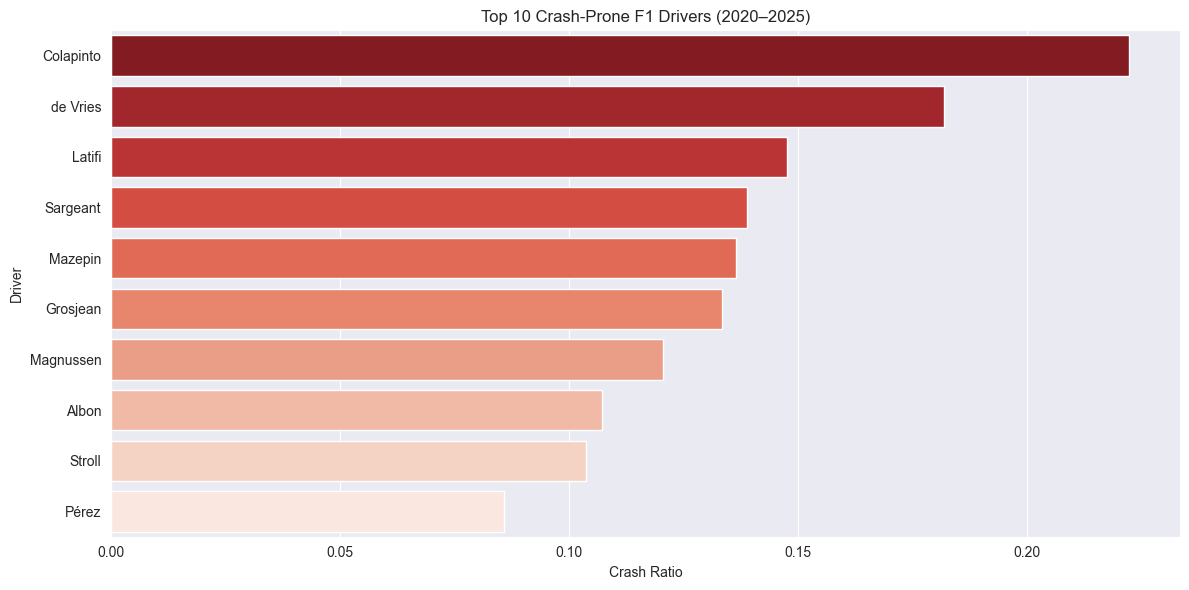

In [33]:
top10 = crash_stats_sorted.head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top10, x="crash_ratio", y="surname", palette="Reds_r", hue="surname", legend=False)
plt.title("Top 10 Crash-Prone F1 Drivers (2020–2025)")
plt.xlabel("Crash Ratio")
plt.ylabel("Driver")
plt.tight_layout()
plt.show()


Winning drivers age

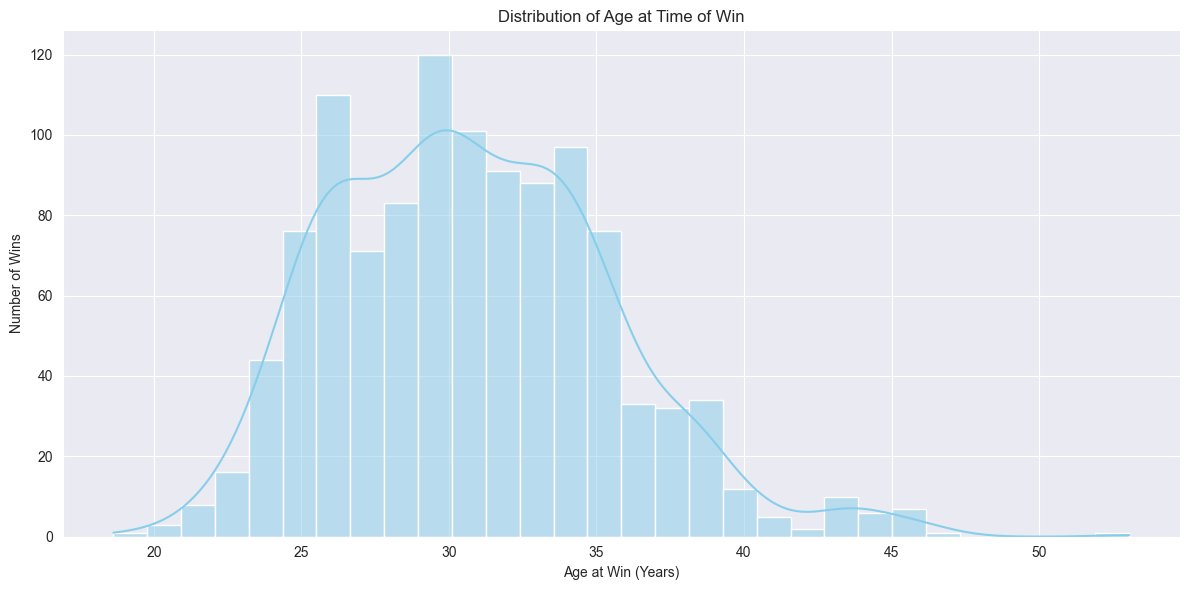

In [23]:
# Filter only winners
winners = results[results["positionOrder"] == 1]

# Merge with race date
winners = winners.merge(races[["raceId", "date", "year"]], on="raceId", how="left")

# Merge with driver birthdates
winners = winners.merge(drivers[["driverId", "surname", "forename", "dob"]], on="driverId", how="left")

# Convert to datetime
winners["date"] = pd.to_datetime(winners["date"])
winners["dob"] = pd.to_datetime(winners["dob"])


# Age in years
winners["age_at_win"] = (winners["date"] - winners["dob"]).dt.days / 365.25



plt.figure(figsize=(12,6))
sns.histplot(winners["age_at_win"], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Age at Time of Win")
plt.xlabel("Age at Win (Years)")
plt.ylabel("Number of Wins")
plt.tight_layout()
plt.show()


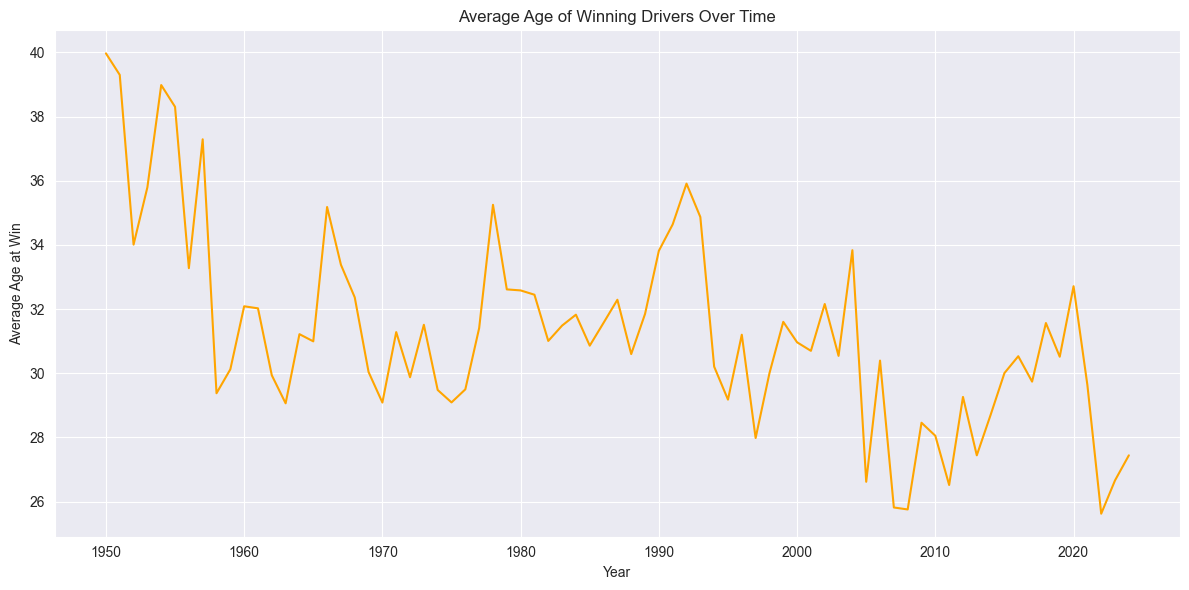

In [24]:
# Group by year and average age
age_by_year = winners.groupby("year")["age_at_win"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=age_by_year, x="year", y="age_at_win", color='orange')
plt.title("Average Age of Winning Drivers Over Time")
plt.xlabel("Year")
plt.ylabel("Average Age at Win")
plt.tight_layout()
plt.show()


Distribution of grid vs final positions

In [25]:
# Merge to include year if filtering by year
results = results.merge(races[["raceId", "year"]], on="raceId", how="left")

# Filter valid entries
grid_vs_finish = results[(results["grid"] > 0) & (results["positionOrder"] > 0)]

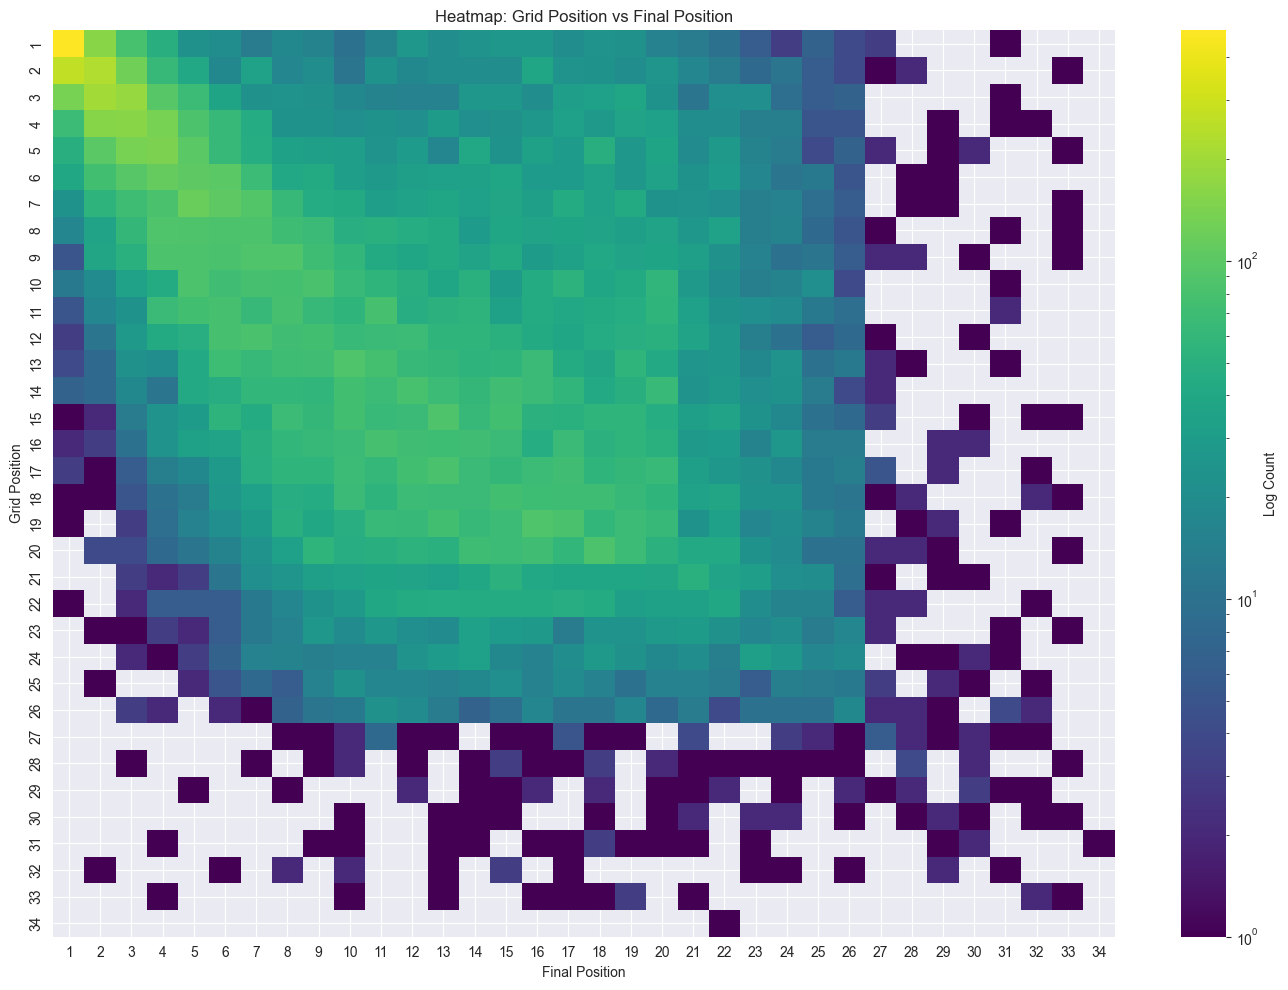

In [26]:
pivot = grid_vs_finish.pivot_table(index="grid", columns="positionOrder", aggfunc="size", fill_value=0)

plt.figure(figsize=(14,10))
sns.heatmap(pivot, cmap="viridis", norm='log', cbar_kws={"label": "Log Count"})
plt.title("Heatmap: Grid Position vs Final Position")
plt.xlabel("Final Position")
plt.ylabel("Grid Position")
plt.tight_layout()
plt.show()


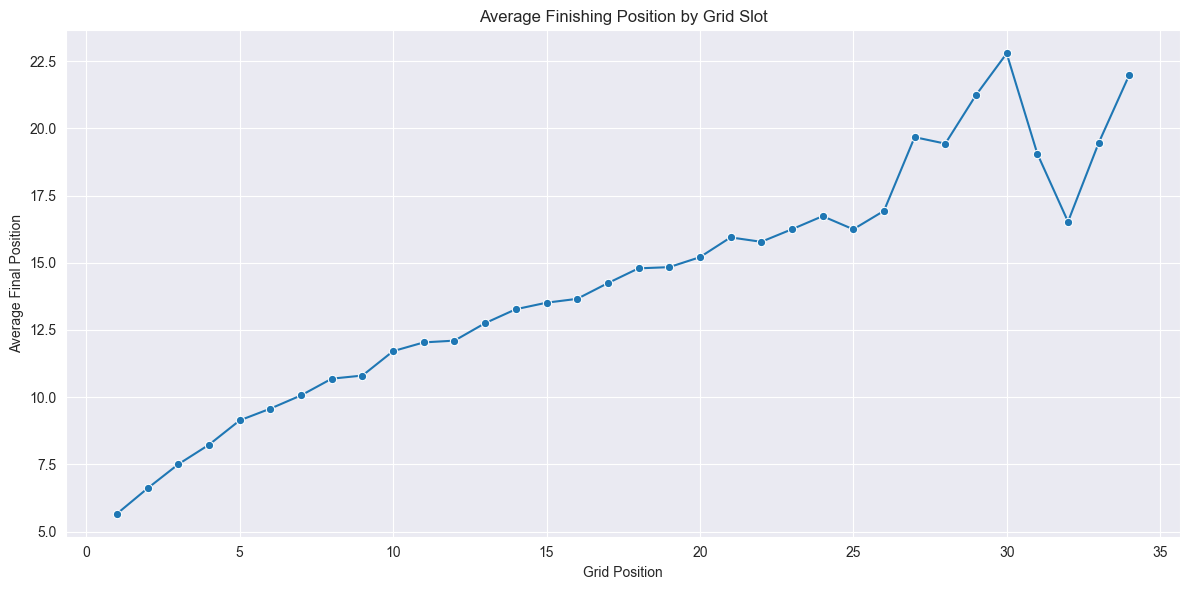

In [27]:
avg_finish_by_grid = grid_vs_finish.groupby("grid")["positionOrder"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=avg_finish_by_grid, x="grid", y="positionOrder", marker="o")
plt.title("Average Finishing Position by Grid Slot")
plt.xlabel("Grid Position")
plt.ylabel("Average Final Position")
plt.tight_layout()
plt.show()


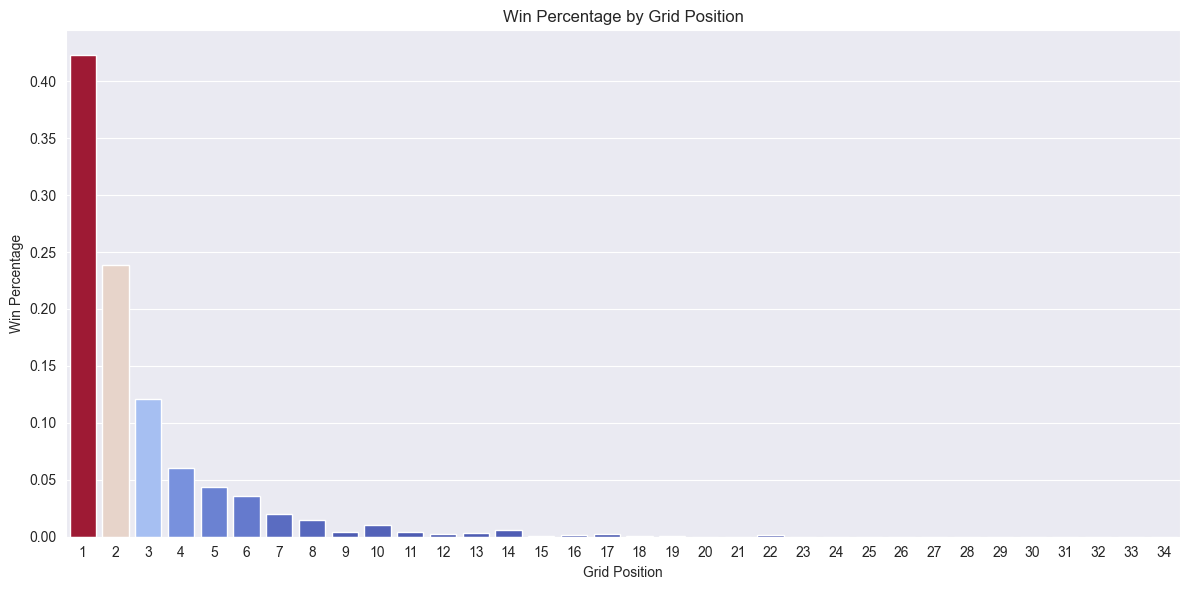

In [34]:
# Count total and wins per grid
total_per_grid = grid_vs_finish.groupby("grid").size()
wins_per_grid = grid_vs_finish[grid_vs_finish["positionOrder"] == 1].groupby("grid").size()

win_ratio = (wins_per_grid / total_per_grid).fillna(0).reset_index(name="win_percent")

plt.figure(figsize=(12,6))
sns.barplot(data=win_ratio, x="grid", y="win_percent", palette="coolwarm", hue="win_percent", legend=False)
plt.title("Win Percentage by Grid Position")
plt.xlabel("Grid Position")
plt.ylabel("Win Percentage")
plt.tight_layout()
plt.show()


Correlation between grid, qualifying, and final position.

Pit stops vs. performance